## Casting a CaffeNet into a Fully Convolutional Network

In [25]:
# original notebook from caffe - https://github.com/BVLC/caffe/blob/master/examples/net_surgery.ipynb

import os, urllib
import mxnet as mx
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple

In [27]:
# fully-connected caffenet
data = mx.symbol.Variable(name="data")
label = mx.symbol.Variable(name="label")

conv1 = mx.symbol.Convolution(data=data, kernel=(11, 11), stride=(4, 4), num_filter=96, name="conv1", num_group=1)
relu1 = mx.symbol.Activation(data=conv1, act_type="relu", name="relu1")
pool1 = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(3, 3), stride=(2, 2), name="pool1")
norm1 = mx.symbol.LRN(data=pool1, alpha=0.0001, beta=0.75, knorm=1, nsize=5, name="norm1")

conv2 = mx.symbol.Convolution(data=norm1, kernel=(5, 5), pad=(2, 2), num_filter=256, name="conv2", num_group=2)
relu2 = mx.symbol.Activation(data=conv2, act_type="relu", name="relu2")
pool2 = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(3, 3), stride=(2, 2), name="pool2")
norm2 = mx.symbol.LRN(data=pool2, alpha=0.0001, beta=0.75, knorm=1, nsize=5,name='norm2')

conv3 = mx.symbol.Convolution(data=norm2,kernel=(3, 3), pad=(1, 1), num_filter=384, name="conv3", num_group=1)
relu3 = mx.symbol.Activation(data=conv3, act_type="relu", name="relu3")                
                              
conv4= mx.symbol.Convolution(data=relu3, kernel=(3, 3), pad=(1, 1), num_filter=384, name="conv4", num_group=2)
relu4= mx.symbol.Activation(data=conv4, act_type="relu", name="relu4")

conv5=mx.symbol.Convolution(data=relu4, kernel=(3, 3), pad=(1, 1), num_filter=256, name="conv5", num_group=2)
relu5=mx.symbol.Activation(data=conv5, act_type="relu", name="relu5")                        
pool5=mx.symbol.Pooling(data=relu5,pool_type="max", kernel=(3, 3), stride=(2, 2), pad=(0,0), name="pool5")
                             
fc6_conv=mx.symbol.Convolution(data=pool5, kernel=(6, 6), num_filter=4096, name="fc6_conv")
relu6=mx.symbol.Activation(data=fc6_conv, act_type="relu", name="relu6")
drop6 = mx.symbol.Dropout(data=relu6, p=0.5, name="drop6")
                             
fc7_conv=mx.symbol.Convolution(data=drop6, kernel=(1, 1), num_filter=4096, name="fc7_conv")
relu7=mx.symbol.Activation(data=fc7_conv, act_type="relu", name="relu7")
drop7 = mx.symbol.Dropout(data=relu7, p=0.5, name="drop7")

fc8_conv=mx.symbol.Convolution(data=drop7, kernel=(1, 1), num_filter=1000, name="fc8_conv")
relu8=mx.symbol.Activation(data=fc8_conv, act_type="relu", name="relu8")
drop8 = mx.symbol.Dropout(data=relu8, p=0.5, name="drop8")
                             
out = mx.symbol.SoftmaxOutput(data=drop8, name="softmax")

In [28]:
# load caffenet params and shaped them for fc layers
net_params = mx.initializer.Load('pre-trained-nets/caffenet/caffenet-0000.params')
for m in sorted(net_params.param):
    print m, net_params.param[m].shape

net_params.param['fc6_conv_weight'] = mx.nd.array(net_params.param['fc6_weight'].asnumpy().ravel().reshape(4096, 256, 6, 6))
net_params.param['fc6_conv_bias'] = net_params.param['fc6_bias']
del net_params.param['fc6_weight']
del net_params.param['fc6_bias']

net_params.param['fc7_conv_weight'] = mx.nd.array(net_params.param['fc7_weight'].asnumpy().ravel().reshape(4096, 4096, 1, 1))
net_params.param['fc7_conv_bias'] = net_params.param['fc7_bias']
del net_params.param['fc7_weight']
del net_params.param['fc7_bias']

net_params.param['fc8_conv_weight'] = mx.nd.array(net_params.param['fc8_weight'].asnumpy().ravel().reshape(1000, 4096, 1, 1))
net_params.param['fc8_conv_bias'] = net_params.param['fc8_bias']
del net_params.param['fc8_weight']
del net_params.param['fc8_bias']
print
for m in sorted(net_params.param):
    print m, net_params.param[m].shape

conv1_bias (96L,)
conv1_weight (96L, 3L, 11L, 11L)
conv2_bias (256L,)
conv2_weight (256L, 48L, 5L, 5L)
conv3_bias (384L,)
conv3_weight (384L, 256L, 3L, 3L)
conv4_bias (384L,)
conv4_weight (384L, 192L, 3L, 3L)
conv5_bias (256L,)
conv5_weight (256L, 192L, 3L, 3L)
fc6_bias (4096L,)
fc6_weight (4096L, 9216L)
fc7_bias (4096L,)
fc7_weight (4096L, 4096L)
fc8_bias (1000L,)
fc8_weight (1000L, 4096L)

conv1_bias (96L,)
conv1_weight (96L, 3L, 11L, 11L)
conv2_bias (256L,)
conv2_weight (256L, 48L, 5L, 5L)
conv3_bias (384L,)
conv3_weight (384L, 256L, 3L, 3L)
conv4_bias (384L,)
conv4_weight (384L, 192L, 3L, 3L)
conv5_bias (256L,)
conv5_weight (256L, 192L, 3L, 3L)
fc6_conv_bias (4096L,)
fc6_conv_weight (4096L, 256L, 6L, 6L)
fc7_conv_bias (4096L,)
fc7_conv_weight (4096L, 4096L, 1L, 1L)
fc8_conv_bias (1000L,)
fc8_conv_weight (1000L, 4096L, 1L, 1L)


In [12]:
# create network representation 
graph = mx.viz.plot_network(symbol=out)

In [12]:
# save graph
graph.format = 'png'
graph.render('ssd-net.gv', view=True)

'ssd-net.gv.png'

In [29]:
mod = mx.mod.Module(symbol=out)
mod.bind(data_shapes=[('data', (1, 3, 451, 451))])
mod.init_params(net_params)

In [30]:
Batch = namedtuple('Batch', ['data'])

def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
        
def get_image(url, show=True):
    filename = url.split("/")[-1]
    urllib.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename

def predict(filename, mod):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
    if img is None:
        return None
    
    img = cv2.resize(img, (451, 451))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 

    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob_map = prob.reshape(1000, 8,8).argmax(axis=0)
    print prob_map
    plt.imshow(prob[0,281])

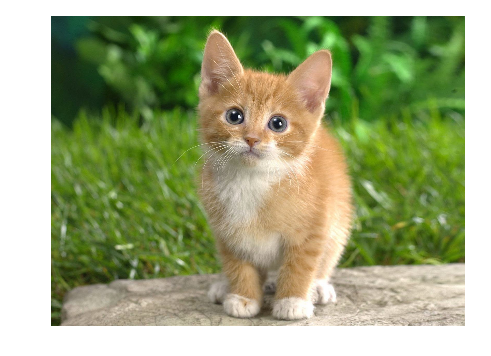

In [31]:
url = 'http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg'
img = get_image(url)

[[281 281 186 186 282 277 151 330]
 [282 282 283 151 285 259 281 904]
 [282 284 283 285 284 259 151 333]
 [278 283 283 287 259 259 151 259]
 [283 358 285 259 285 283 259 259]
 [283 259 358 356 356 259 283 279]
 [905 373 374 371 283 259 279 318]
 [283 283 371 229 332 283 282 272]]


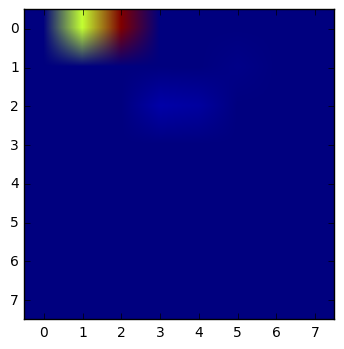

In [34]:
predict(img, mod)

In [33]:
# save symbol and params for future use
mod.save_params('caffenet-0001.params')
mod.symbol.save('caffenet-symbol.json')